<a href="https://colab.research.google.com/github/FrancescoManca-FM/Project_MLDL/blob/main/incrementalLearningWithoutForgetting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms 
import torch.nn.functional as F
import copy
from torch.nn.init import xavier_uniform_ 
from torch.nn.init import kaiming_uniform_

### DATA LOADER

In [2]:
# we build a transform to normalize images: Data normalization is an important step which ensures 
# each input parameter (pixel, in this case) has a similar data distribution. This makes convergence 
# faster while training the network.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 128

trainset_raw = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                         download=True, transform=transform)

for i in range(len(trainset_raw)):
  if(i==0):
    trainset = [[trainset_raw[i][0], trainset_raw[i][1]]]
  else:
    trainset.append([trainset_raw[i][0], trainset_raw[i][1]])


# DataLoader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
# batch_size = how many samples per batch to load
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### NETWORK

In [3]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)

        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def addOutputNodes(self, num_new_outputs):
        in_features = self.fc.in_features
        out_features = self.fc.out_features
        weight = self.fc.weight.data

        self.fc = nn.Linear(in_features, out_features + num_new_outputs)

        #xavier initialization
        xavier_uniform_(self.fc.weight)
        
        self.fc.weight.data[:out_features] = weight
        


def resnet20(pretrained=False, **kwargs):
    n = 3
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet56(pretrained=False, **kwargs):
    n = 9
    model = ResNet(Bottleneck, [n, n, n], **kwargs)
    return model

In [4]:
net = resnet32()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
net.to(device)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

### LOSS & PARAMETERS

In [5]:
lr = 1
decay = 0.0001
epochs = 30
momentum = 0.9
factor = 5

In [6]:
import torch.optim as optim
import torch.nn as nn


bceLoss = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr = lr, weight_decay=decay,momentum= momentum)

### TRAINING BCE LOSS

In [7]:
def training(trainloader, iteration, network, device, epochs, num_classes):
  num_classes_till_previous_step = iteration * num_classes
  num_current_classes = num_classes_till_previous_step + num_classes
  total_classes = 100
  distillation_loss = 0
  old_net = copy.deepcopy(network)
  old_net.eval()
  
  if (iteration != 0):
    # add 10 output nodes to the network
    network.addOutputNodes(num_classes)
    network.to(device)

  optimizer = optim.SGD(net.parameters(), lr = lr, weight_decay=decay,momentum= momentum)
  print("before training: ", network.fc.weight.data)
 
  #train the network
  for epoch in range(epochs):
    if (epoch == 49 or epoch == 63):
      optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / factor

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      inputs = data[0].to(device)
      labels = data[1].to(device)
      optimizer.zero_grad()
      logits = network(inputs)
      distilled_targets = get_one_hot(labels, num_current_classes, device)
      
      if iteration > 0:
        logits_old = old_net(inputs)
        distilled_targets[:, 0:num_classes_till_previous_step] = torch.sigmoid(logits_old)

      loss = bceLoss(logits, distilled_targets) * (num_current_classes / total_classes)
      # redesign the weights evaluating the performance of the network
      loss.backward()
      # update parameters
      optimizer.step()
      running_loss += loss.item()
      if i % 20 == 19:    
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
        running_loss = 0.0

  return network

In [8]:
def get_one_hot(target,num_class, device):
  one_hot=torch.zeros(target.shape[0],num_class).to(device)
  one_hot=one_hot.scatter(dim=1,index=target.long().view(-1,1),value=1.)
  return one_hot

### TEST

In [9]:
"""
def test(testloader, iteration, network, acc):

  correct = 0
  total = 0
  print("ITERATION: ", iteration)
  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)

          # calculate outputs by running images through the network
          outputs = network.forward(images)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
         
        
  acc.append(100*correct/total)
  print(f'Accuracy of the network on the {iteration} iteration: %d %%' % (100 * correct / total))
  """

'\ndef test(testloader, iteration, network, acc):\n\n  correct = 0\n  total = 0\n  print("ITERATION: ", iteration)\n  \n  # since we\'re not training, we don\'t need to calculate the gradients for our outputs\n  with torch.no_grad():\n      for data in testloader:\n          images, labels = data[0].to(device), data[1].to(device)\n\n          # calculate outputs by running images through the network\n          outputs = network.forward(images)\n\n          # the class with the highest energy is what we choose as prediction\n          _, predicted = torch.max(outputs.data, 1)\n          total += labels.size(0)\n          correct += (predicted == labels).sum().item()\n         \n        \n  acc.append(100*correct/total)\n  print(f\'Accuracy of the network on the {iteration} iteration: %d %%\' % (100 * correct / total))\n  '

### EXECUTION 

In [10]:
"""
# divided our dataset into sample of 10 classes each
# train the network on the first 10 classes
# evaluate the network on the first 10 classes
# train the network on the second 10 classes (adding 10 output layers)
# evaluate the network on the first 20 classes
iterations= 10 
num_classes = 10
test_set = [] #initialized here because we test over all the classes not only those one in which I train
acc = []
import random
#indices = list(range(0,100))
#random.shuffle(indices)
for i in range(iterations):
  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)
  train_iter = [] 
  for j in range(len(trainset)):
    if(trainset[j][-1] in classes_current_iter):
      test_set.append(trainset[j]) 
      train_iter.append(trainset[j])


  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)
  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2) 
  training(train_loader, i, net, device, epochs, num_classes) # Train the network with 10 classes at a time

  test(valid_loader, i, net, acc) # Test the network with all classes seen until this iteration
  """

'\n# divided our dataset into sample of 10 classes each\n# train the network on the first 10 classes\n# evaluate the network on the first 10 classes\n# train the network on the second 10 classes (adding 10 output layers)\n# evaluate the network on the first 20 classes\niterations= 10 \nnum_classes = 10\ntest_set = [] #initialized here because we test over all the classes not only those one in which I train\nacc = []\nimport random\n#indices = list(range(0,100))\n#random.shuffle(indices)\nfor i in range(iterations):\n  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)\n  train_iter = [] \n  for j in range(len(trainset)):\n    if(trainset[j][-1] in classes_current_iter):\n      test_set.append(trainset[j]) \n      train_iter.append(trainset[j])\n\n\n  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)\n  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2

### CONFUSION MATRIX

In [11]:
"""
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix = torch.zeros(100,100)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valid_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net.forward(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
          confusion_matrix[t.long(),p.long()] += 1

plt.figure()
plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
"""

'\nfrom sklearn.metrics import plot_confusion_matrix\nimport matplotlib.pyplot as plt\n\nconfusion_matrix = torch.zeros(100,100)\n\ncorrect = 0\ntotal = 0\n# since we\'re not training, we don\'t need to calculate the gradients for our outputs\nwith torch.no_grad():\n    for data in valid_loader:\n        images, labels = data[0].to(device), data[1].to(device)\n        # calculate outputs by running images through the network\n        outputs = net.forward(images)\n        # the class with the highest energy is what we choose as prediction\n        _, predicted = torch.max(outputs.data, 1)\n        total += labels.size(0)\n        correct += (predicted == labels).sum().item()\n\n        for t, p in zip(labels.view(-1), predicted.view(-1)):\n          confusion_matrix[t.long(),p.long()] += 1\n\nplt.figure()\nplt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)\nprint(\'Accuracy of the network on the 10000 test images: %d %%\' % (100 * correct / total))\n'

### TEST (CONFUSION EACH STEP)



In [12]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def test(testloader, iteration, network, acc):
  confusion_matrix = torch.zeros(iteration*10+10,iteration*10+10)
  print("confusion matrix shape: ", confusion_matrix.shape)
  correct = 0
  total = 0
  print("ITERATION: ", iteration)
  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)

          # calculate outputs by running images through the network
          outputs = network.forward(images)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
         
          for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(),p.long()] += 1

  plt.figure()
  plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.plasma)
  plt.show()
  acc.append(100*correct/total)
  print(f'Accuracy of the network on the {iteration} iteration: %d %%' % (100 * correct / total))

### RANDOM CLASSES


EXECUTION

In [13]:
import random
indices = list(range(0,100))
random.shuffle(indices)
dict_classes = dict(zip(indices,range(100)))
for i in range(len(trainset)):
  trainset[i][1] = dict_classes[trainset[i][1]]

Train the network, iteration:  0  on classes:  range(0, 10)
before training:  tensor([[-6.3498e-02,  1.1210e-01, -1.3788e-02,  3.1274e-02, -4.6851e-02,
         -4.2628e-03, -1.1135e-01,  1.2012e-01, -1.2710e-02,  7.8863e-02,
          1.1938e-01, -9.0784e-02, -5.6986e-02, -4.2646e-02, -1.0545e-01,
          2.1907e-02,  4.0610e-02, -6.2379e-02, -7.9124e-02,  1.0167e-01,
          1.2095e-01, -8.9677e-02, -1.7733e-02, -3.4623e-02,  1.0746e-01,
         -1.8046e-02, -1.1626e-01,  3.2486e-02,  1.2122e-01, -4.0854e-02,
          6.6082e-02, -8.9463e-02,  6.9276e-03,  1.8394e-02,  7.7426e-02,
          8.8702e-02, -8.0552e-02, -7.2759e-02,  4.1806e-02, -1.3864e-02,
         -2.2892e-02, -4.0852e-02,  1.0024e-01, -1.6392e-02,  7.2795e-02,
          7.1492e-02, -1.5284e-02,  7.2415e-02,  5.0230e-02, -1.0281e-01,
          4.7741e-02, -9.7248e-02,  2.3327e-02, -1.8383e-02, -1.0437e-01,
          2.5343e-02, -5.3377e-02,  6.2465e-02, -1.6827e-02,  1.2006e-01,
         -3.5766e-02, -2.7988e-02,

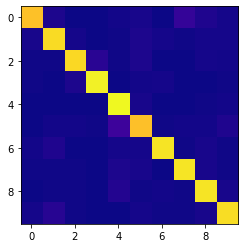

Accuracy of the network on the 0 iteration: 90 %
Train the network, iteration:  1  on classes:  range(10, 20)
before training:  tensor([[-0.1024,  0.2117,  0.1029,  ...,  0.0305, -0.1195, -0.1155],
        [-0.1616, -0.1919,  0.1865,  ..., -0.2093, -0.1103, -0.1831],
        [-0.1776, -0.1656,  0.0080,  ..., -0.1973,  0.1343,  0.2237],
        ...,
        [-0.0187, -0.0671, -0.2619,  ..., -0.1654,  0.1180,  0.0631],
        [ 0.0067,  0.2265,  0.1211,  ..., -0.0179,  0.1129, -0.1342],
        [-0.2589,  0.1941, -0.0045,  ...,  0.0443, -0.2203,  0.2387]],
       device='cuda:0')
[1,    20] loss: 0.062
[1,    40] loss: 0.048
[2,    20] loss: 0.044
[2,    40] loss: 0.042
[3,    20] loss: 0.040
[3,    40] loss: 0.040
[4,    20] loss: 0.039
[4,    40] loss: 0.038
[5,    20] loss: 0.038
[5,    40] loss: 0.036
[6,    20] loss: 0.037
[6,    40] loss: 0.036
[7,    20] loss: 0.035
[7,    40] loss: 0.034
[8,    20] loss: 0.033
[8,    40] loss: 0.033
[9,    20] loss: 0.036
[9,    40] loss: 0.036


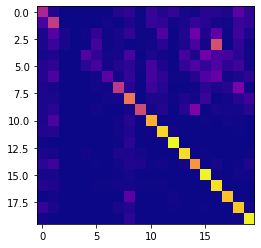

Accuracy of the network on the 1 iteration: 56 %
Train the network, iteration:  2  on classes:  range(20, 30)
before training:  tensor([[ 0.0274,  0.2927,  0.1831,  ...,  0.1522, -0.0736, -0.0346],
        [-0.0872, -0.0728,  0.2335,  ..., -0.1291, -0.1373, -0.0347],
        [-0.0595, -0.1339, -0.0363,  ..., -0.1625, -0.0767,  0.0189],
        ...,
        [-0.1198,  0.0103,  0.0243,  ..., -0.2208,  0.0464, -0.0749],
        [-0.1054,  0.1473,  0.0719,  ..., -0.0110, -0.0570, -0.1650],
        [ 0.1754, -0.1264, -0.0853,  ...,  0.1037,  0.0594, -0.0228]],
       device='cuda:0')
[1,    20] loss: 0.080
[1,    40] loss: 0.061
[2,    20] loss: 0.058
[2,    40] loss: 0.056
[3,    20] loss: 0.055
[3,    40] loss: 0.053
[4,    20] loss: 0.051
[4,    40] loss: 0.052
[5,    20] loss: 0.051
[5,    40] loss: 0.050
[6,    20] loss: 0.051
[6,    40] loss: 0.050
[7,    20] loss: 0.050
[7,    40] loss: 0.050
[8,    20] loss: 0.052
[8,    40] loss: 0.051
[9,    20] loss: 0.049
[9,    40] loss: 0.048


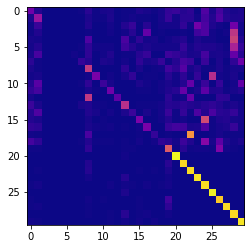

Accuracy of the network on the 2 iteration: 42 %
Train the network, iteration:  3  on classes:  range(30, 40)
before training:  tensor([[-0.0503,  0.2452,  0.0832,  ...,  0.0938, -0.0919,  0.0186],
        [-0.0689, -0.0264,  0.1725,  ..., -0.0560, -0.1609, -0.0342],
        [-0.0209, -0.0797, -0.0775,  ..., -0.0713, -0.0826, -0.0714],
        ...,
        [-0.0036,  0.2130,  0.0930,  ...,  0.0836, -0.2327, -0.0266],
        [ 0.1257, -0.0453,  0.2183,  ..., -0.2142,  0.0515,  0.1641],
        [ 0.1517, -0.1557, -0.0373,  ..., -0.0326,  0.1213, -0.0477]],
       device='cuda:0')
[1,    20] loss: 0.095
[1,    40] loss: 0.083
[2,    20] loss: 0.080
[2,    40] loss: 0.078
[3,    20] loss: 0.077
[3,    40] loss: 0.076
[4,    20] loss: 0.074


In [ ]:
#TRYING TO RANDOMIZE CLASSES


# divided our dataset into sample of 10 classes each
# train the network on the first 10 classes
# evaluate the network on the first 10 classes
# train the network on the second 10 classes (adding 10 output layers)
# evaluate the network on the first 20 classes
iterations = 10
num_classes = 10
test_set = [] #initialized here because we test over all the classes not only those one in which I train
acc = []
#import random
#indices = list(range(0,100))
#random.shuffle(indices)
for i in range(iterations):
  #classes_current_iter = dict(zip(indices[i*num_classes : i*num_classes+num_classes],range(i*num_classes,i*num_classes+num_classes)))
  # print(classes_current_iter)
  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)
  train_iter = []
  for j in range(len(trainset)):
    if(trainset[j][-1] in classes_current_iter):
      test_set.append(trainset[j]) 
      train_iter.append(trainset[j])

  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)
  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2) 
  print("Train the network, iteration: ", i, " on classes: ", classes_current_iter)
  #print("before training: ", net.fc.weight.data)
  net = training(train_loader, i, net, device, epochs, num_classes) # Train the network with 10 classes at a time
  print("after training: ", net.fc.weight.data)
  test(valid_loader, i, net, acc) # Test the network with all classes seen until this iteration